In [2]:
import time
import torch
import numpy as np
from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_moons
import sys
sys.path.append("/home/u5649209/workspace/flow_matching")  # Adjust the path as necessary to import flow_matching_utils
from flow_matching_utils import MLP, evaluate_result

# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()
import numpy as np
from flow_matching_utils import train_moon_gen
from flow_matching_utils import reinit_lora

import os
import pickle
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
lr = 0.001
batch_size = 4096
iterations = 3000
print_every = 50
hidden_dim = 512
gradient_base = 3
gradient_iter = 4000
is_pre_train = False
is_lora = True
is_eval = False
is_reinit = False
mode = "new"
lora_init_mode = "lora-one"

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


## Boss Ordered 1

0 step lora-ga weights & n steps Full-P Finetuned weight

lora baseline weights & n steps fft 

Step: 0, Module: main.0.weight, LR: 0.001, Distance: 120.37156677246094
Step: 0, Module: main.2.weight, LR: 0.001, Distance: 89.70901489257812
Step: 0, Module: main.4.weight, LR: 0.001, Distance: 86.68936920166016
Step: 0, Module: main.6.weight, LR: 0.001, Distance: 89.95577239990234
Step: 50, Module: main.0.weight, LR: 0.001, Distance: 120.19808959960938
Step: 50, Module: main.2.weight, LR: 0.001, Distance: 87.9925308227539
Step: 50, Module: main.4.weight, LR: 0.001, Distance: 85.69306182861328
Step: 50, Module: main.6.weight, LR: 0.001, Distance: 89.78826904296875
Step: 100, Module: main.0.weight, LR: 0.001, Distance: 120.07176971435547
Step: 100, Module: main.2.weight, LR: 0.001, Distance: 87.46971893310547
Step: 100, Module: main.4.weight, LR: 0.001, Distance: 85.50652313232422
Step: 100, Module: main.6.weight, LR: 0.001, Distance: 89.71559143066406
Step: 150, Module: main.0.weight, LR: 0.001, Distance: 120.01795196533203
Step: 150, Module: main.2.weight, LR: 0.001, Distance: 87.09

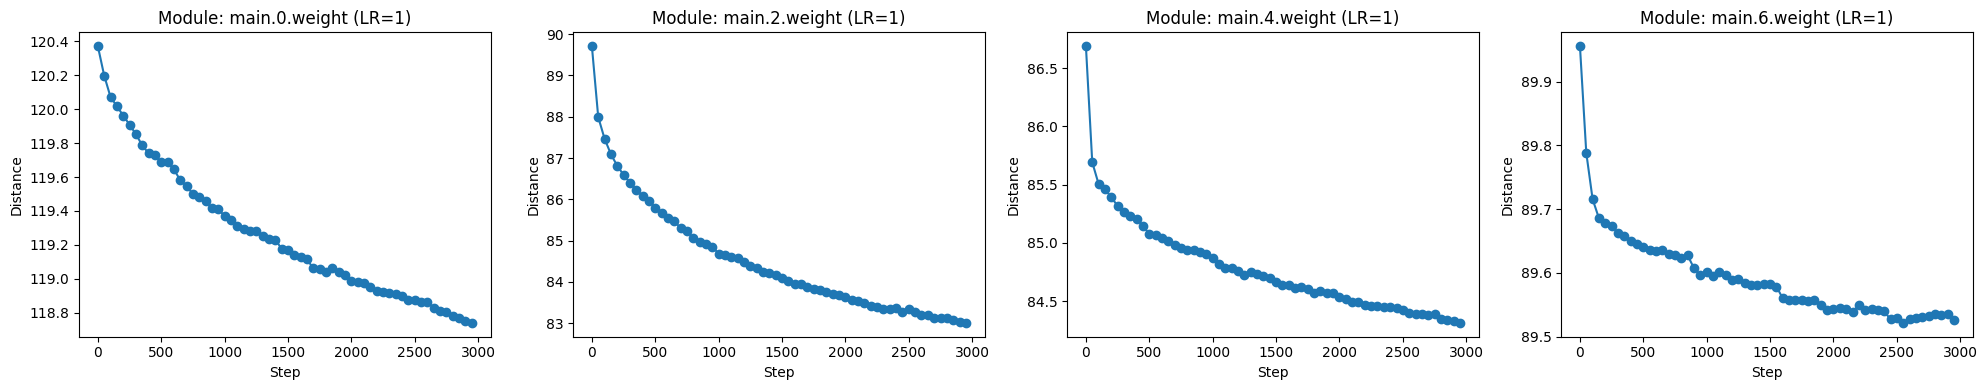

In [ ]:
# checkpoint_steps = [1999,7999,13999,19999]
vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
vf_lora_reinit.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
lora_config = LoraConfig(
    r=2,
    lora_alpha=4,
    target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)

# Lora-v init
# gamma = 9
# with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
#     named_grad = pickle.load(f)
# _ = reinit_lora(vf_lora_reinit, gamma, named_grad)
# state_dict = vf_lora_reinit.state_dict()

# lora init
ckpt = 2000

weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/lora-one_pretrainiter_16000_0_15000_gamma81/{ckpt}_new'
# Full model finetuned weights
# peft_config = PeftConfig.from_pretrained(weight_path)
vf_lora_compare = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
vf_lora_compare = PeftModel.from_pretrained(vf_lora_compare, weight_path)
state_dict = vf_lora_compare.state_dict()

layer_num  = [0, 2, 4, 6]

# Select modules for comparison
module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                #    "main.8.weight", "main.8.bias"
                ]
checkpoint_steps = range(0, 3000, 50)


distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/fft_16000/{ckpt}_new.pth'
    # Full model finetuned weights
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for i in range(len(layer_num)):
        module = f'main.{layer_num[i]}.weight'
        if 'bias' in module:
            continue
        compared_weights = loaded_weights[module].to(device)

        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

        lora_combined_weights = loraB_weights @ loraA_weights
        lora_combined_weights = lora_combined_weights + state_dict[f'base_model.model.main.{layer_num[i]}.base_layer.weight']
        # distance = torch.norm(after_optimization_weights - weights).item()
        # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
        dot_product = np.dot(compared_weights.flatten().cpu().numpy(), lora_combined_weights.flatten().cpu().numpy())
        norm_after = np.linalg.norm(compared_weights.flatten().cpu().numpy())
        norm_weights = np.linalg.norm(lora_combined_weights.flatten().cpu().numpy())
        distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
        # Print the step, module, learning rate, and distance
        # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
        print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
        distance_module_dict[(ckpt, module, 1)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")

plt.tight_layout()

plt.show()

## Boss Ordered 1 gamma variance

0 step lora-ga weights & n steps Full-P Finetuned weight

Reinitializing Lora:   0%|          | 0/63 [00:00<?, ?it/s]

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 497.30it/s]


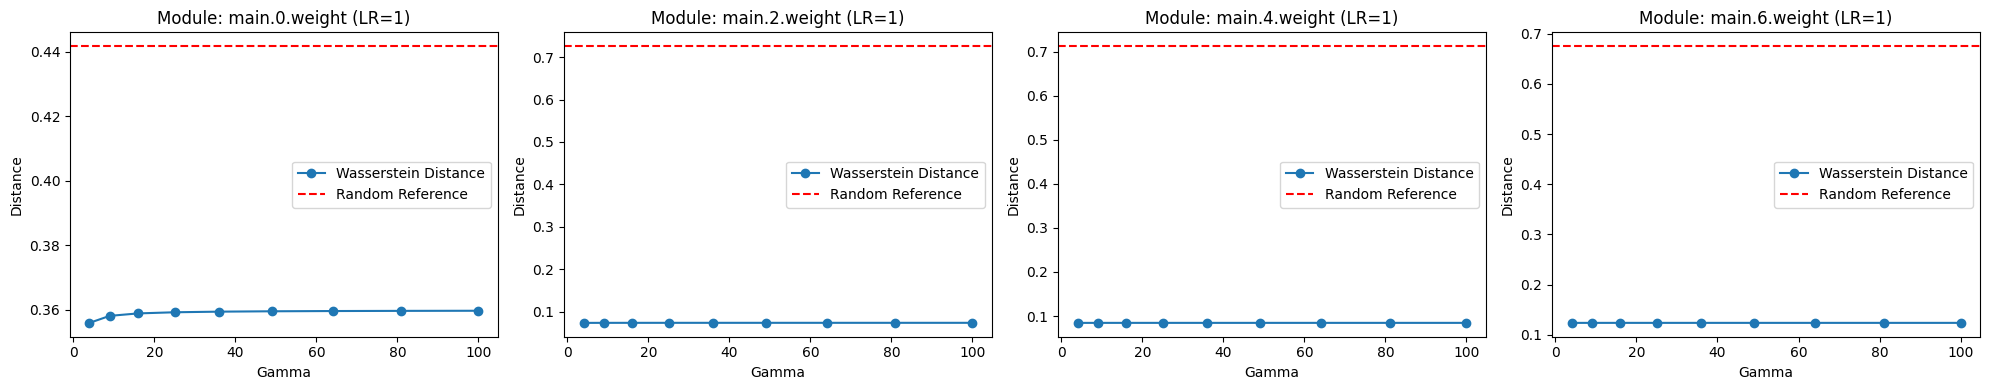

In [6]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
gamma_list = [4, 9 , 16, 25, 36, 49, 64, 81, 100]
distance_module_dict = {}
for gamma in gamma_list:
    with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
        named_grad = pickle.load(f)
    vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    lora_config = LoraConfig(
        r=2,
        lora_alpha=16,
        target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
        init_lora_weights="gaussian",
    )
    vf_lora_reinit.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
    vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
    
    _ = reinit_lora(vf_lora_reinit, gamma, named_grad)
    state_dict = vf_lora_reinit.state_dict()


    layer_num  = [0, 2, 4, 6]

    # Select modules for comparison
    module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                    "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                    #    "main.8.weight", "main.8.bias"
                    ]
    checkpoint_steps = [1999, 3999, 5999, 7999, 9999]
    ckpt = 1999

    
    # Calculate distance between original weights + lora_weights & trained weights


    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_{ckpt}.pth'
    # Full model finetuned weights
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for i in range(len(layer_num)):
        module = f'main.{layer_num[i]}.weight'
        if 'bias' in module:
            continue
        compared_weights = loaded_weights[module].to(device)

        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

        lora_combined_weights = loraB_weights @ loraA_weights

        
        # distance = torch.norm(after_optimization_weights - weights).item()

        distance = wasserstein_distance(compared_weights.cpu().numpy().flatten(), lora_combined_weights.cpu().numpy().flatten())
        dis_random = wasserstein_distance(compared_weights.cpu().numpy().flatten(), torch.randn_like(lora_combined_weights).cpu().numpy().flatten())

        # dot_product = np.dot(compared_weights.flatten().cpu().numpy(), lora_combined_weights.flatten().cpu().numpy())
        # norm_after = np.linalg.norm(compared_weights.flatten().cpu().numpy())
        # norm_weights = np.linalg.norm(lora_combined_weights.flatten().cpu().numpy())
        # distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180

        # dot_product = np.dot(compared_weights.flatten().cpu().numpy(), torch.randn_like(lora_combined_weights).flatten().cpu().numpy())
        # norm_after = np.linalg.norm(compared_weights.flatten().cpu().numpy())
        # norm_weights = np.linalg.norm(torch.randn_like(lora_combined_weights).flatten().cpu().numpy())
        # dis_random = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180


        # print(f"Gamma: {gamma}, Module: {module}, LR: {1}, Distance: {distance}")
        distance_module_dict[(gamma, module, 1)] = distance
        if (module, "random") not in distance_module_dict:
            distance_module_dict[(module, "random")] = dis_random

# Plot distance vs gamma for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    gammas = gamma_list
    distances = [distance_module_dict[(gamma, module, lr_fixed)] for gamma in gammas]
    axs[idx].plot(gammas, distances, marker='o', label='Wasserstein Distance')
    # Plot a horizontal line for the single random reference value
    random_ref = distance_module_dict[(module, "random")]
    axs[idx].axhline(y=random_ref, linestyle='--', color='red', label='Random Reference')
    axs[idx].set_xlabel("Gamma")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
    axs[idx].legend()

plt.tight_layout()

plt.show()

## Boss Ordered 2

0 step lora-one weights & n steps LoRA Finetuned weight

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 358.83it/s]
/tmp/ipykernel_3210991/2052811970.py:61: RuntimeWarning: invalid value encountered in scalar divide
  distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/0_new
Step: 0, Module: main.0.weight, LR: 0.001, Distance: nan
Step: 0, Module: main.2.weight, LR: 0.001, Distance: nan
Step: 0, Module: main.4.weight, LR: 0.001, Distance: nan
Step: 0, Module: main.6.weight, LR: 0.001, Distance: nan
/home/u5649209/workspace/flow_matching/ckpts/lora_16000/50_new
Step: 50, Module: main.0.weight, LR: 0.001, Distance: 57.54113006591797
Step: 50, Module: main.2.weight, LR: 0.001, Distance: 75.38655853271484
Step: 50, Module: main.4.weight, LR: 0.001, Distance: 83.53636169433594
Step: 50, Module: main.6.weight, LR: 0.001, Distance: 88.08222961425781
/home/u5649209/workspace/flow_matching/ckpts/lora_16000/100_new
Step: 100, Module: main.0.weight, LR: 0.001, Distance: 60.65687561035156
Step: 100, Module: main.2.weight, LR: 0.001, Distance: 78.14323425292969
Step: 100, Module: main.4.weight, LR: 0.001, Distance: 85.95777130126953
Step: 100, Module: main.6.weight, LR: 0.001, Distance: 88.86624908447266
/ho

KeyError: (2000, 'main.0.weight', 1)

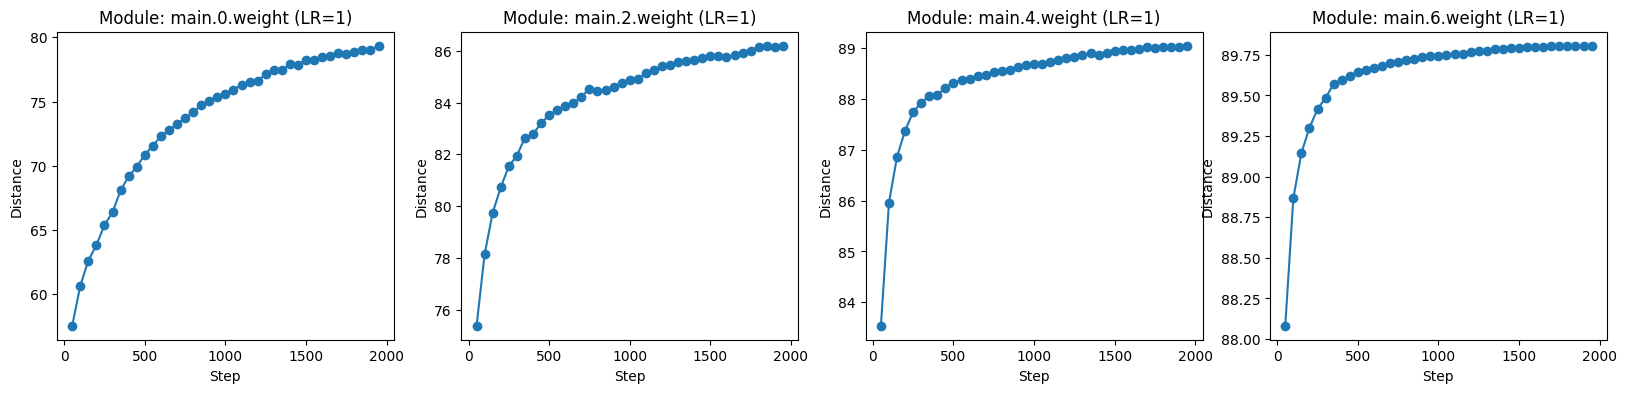

In [3]:
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
# checkpoint_steps = [1999,7999,13999,19999]
vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf_lora_reinit.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
# print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 81
gamma_list = [4, 9, 16, 25, 36, 49, 64, 81, 100]
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/fullP16000_step0_data_new_iter_15000.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf_lora_reinit, gamma, named_grad, init_mode = "lora-one")
state_dict = vf_lora_reinit.state_dict()


layer_num  = [0, 2, 4, 6]

# Select modules for comparison
module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                #    "main.8.weight", "main.8.bias"
                ]
checkpoint_steps = range(0, 2000, 50)

distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/lora_16000/{ckpt}_new'
    # Full model finetuned weights
    # peft_config = PeftConfig.from_pretrained(weight_path)
    vf_lora_compare = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    vf_lora_compare = PeftModel.from_pretrained(vf_lora_compare, weight_path)
    
    print(weight_path)
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights = loraB_weights @ loraA_weights

        # Load lora_combined weights for the compare model
        loraB_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights_compare = loraB_weights_compare @ loraA_weights_compare
        
        # distance = torch.norm(after_optimization_weights - weights).item()
        # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
        weight_1=lora_combined_weights
        weight_2=lora_combined_weights_compare
        
        dot_product = np.dot(weight_1.flatten().cpu().numpy(), weight_2.flatten().cpu().numpy())
        norm_after = np.linalg.norm(weight_1.flatten().cpu().numpy())
        norm_weights = np.linalg.norm(weight_2.flatten().cpu().numpy())
        distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
        # Print the step, module, learning rate, and distance
        # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
        print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
        distance_module_dict[(ckpt, module, 1)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(2000, 'main.0.weight', 1)])
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()

## Boss Ordered 2.1

0 step lora-one weights & n steps lora-one Finetuned weight

/home/u5649209/workspace/flow_matching/ckpts/lora_16000/0_new
Step: 0, Module: main.0.weight, LR: 0.001, Distance: nan
Step: 0, Module: main.2.weight, LR: 0.001, Distance: nan
Step: 0, Module: main.4.weight, LR: 0.001, Distance: nan
Step: 0, Module: main.6.weight, LR: 0.001, Distance: nan
/home/u5649209/workspace/flow_matching/ckpts/lora_16000/50_new
Step: 50, Module: main.0.weight, LR: 0.001, Distance: 85.65814971923828
Step: 50, Module: main.2.weight, LR: 0.001, Distance: 76.56449127197266
Step: 50, Module: main.4.weight, LR: 0.001, Distance: 79.04901123046875
Step: 50, Module: main.6.weight, LR: 0.001, Distance: 89.57669830322266
/home/u5649209/workspace/flow_matching/ckpts/lora_16000/100_new
Step: 100, Module: main.0.weight, LR: 0.001, Distance: 84.48637390136719
Step: 100, Module: main.2.weight, LR: 0.001, Distance: 71.90528869628906
Step: 100, Module: main.4.weight, LR: 0.001, Distance: 73.40077209472656
Step: 100, Module: main.6.weight, LR: 0.001, Distance: 88.33478546142578
/ho

/tmp/ipykernel_4956/1321515714.py:66: RuntimeWarning: invalid value encountered in scalar divide
  distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/200_new
Step: 200, Module: main.0.weight, LR: 0.001, Distance: 83.16777801513672
Step: 200, Module: main.2.weight, LR: 0.001, Distance: 66.19332885742188
Step: 200, Module: main.4.weight, LR: 0.001, Distance: 70.18569946289062
Step: 200, Module: main.6.weight, LR: 0.001, Distance: 87.6063232421875
/home/u5649209/workspace/flow_matching/ckpts/lora_16000/250_new
Step: 250, Module: main.0.weight, LR: 0.001, Distance: 82.4576644897461
Step: 250, Module: main.2.weight, LR: 0.001, Distance: 64.44347381591797
Step: 250, Module: main.4.weight, LR: 0.001, Distance: 69.54934692382812
Step: 250, Module: main.6.weight, LR: 0.001, Distance: 87.58517456054688
/home/u5649209/workspace/flow_matching/ckpts/lora_16000/300_new
Step: 300, Module: main.0.weight, LR: 0.001, Distance: 82.12145233154297
Step: 300, Module: main.2.weight, LR: 0.001, Distance: 63.442054748535156
Step: 300, Module: main.4.weight, LR: 0.001, Distance: 69.36736297607422
Step: 

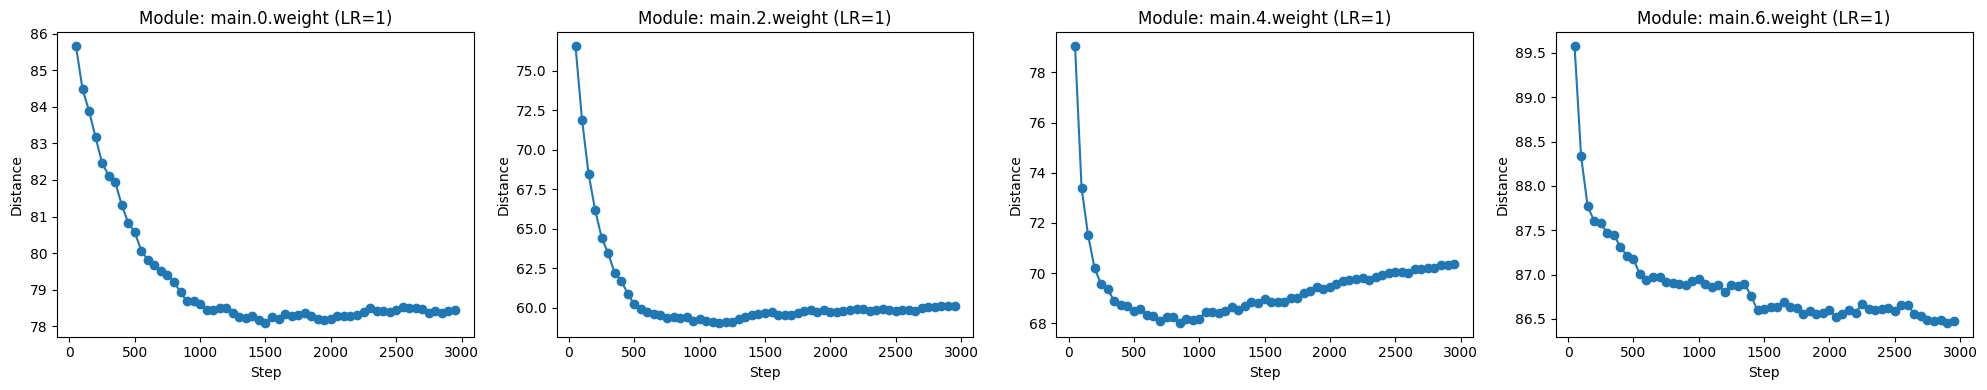

In [9]:
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf_lora_reinit.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_19999.pth", map_location=device))
vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
# print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

# gamma = 81
# gamma_list = [4, 9, 16, 25, 36, 49, 64, 81, 100]
# with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/fullP16000_step0_data_new_iter_15000.pkl', 'rb') as f:
#     named_grad = pickle.load(f)
# _ = reinit_lora(vf_lora_reinit, gamma, named_grad, init_mode = "lora-one")
weight_path = "/home/u5649209/workspace/flow_matching/ckpts/lora-one_pretrainiter_16000_0_15000_gamma81/2000_new"
# weight_path = "/home/u5649209/workspace/flow_matching/ckpts/lora_16000/1000_new"
# Full model finetuned weights
# peft_config = PeftConfig.from_pretrained(weight_path)
vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
vf_lora_reinit = PeftModel.from_pretrained(vf_lora_reinit, weight_path)
state_dict = vf_lora_reinit.state_dict()


layer_num  = [0, 2, 4, 6]

# Select modules for comparison
module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                #    "main.8.weight", "main.8.bias"
                ]
checkpoint_steps = range(0, 3000, 50)

distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:
    # weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/lora-one_pretrainiter_16000_0_15000_gamma81/{ckpt}_new'
    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/lora_16000/{ckpt}_new'
    # Full model finetuned weights
    # peft_config = PeftConfig.from_pretrained(weight_path)
    vf_lora_compare = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    vf_lora_compare = PeftModel.from_pretrained(vf_lora_compare, weight_path)
    
    print(weight_path)
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights = loraB_weights @ loraA_weights

        # Load lora_combined weights for the compare model
        loraB_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights_compare = loraB_weights_compare @ loraA_weights_compare
        
        # distance = torch.norm(after_optimization_weights - weights).item()
        # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
        weight_1=lora_combined_weights
        weight_2=lora_combined_weights_compare
        
        dot_product = np.dot(weight_1.flatten().cpu().numpy(), weight_2.flatten().cpu().numpy())
        norm_after = np.linalg.norm(weight_1.flatten().cpu().numpy())
        norm_weights = np.linalg.norm(weight_2.flatten().cpu().numpy())
        distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
        # Print the step, module, learning rate, and distance
        # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
        print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
        distance_module_dict[(ckpt, module, 1)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(1950, 'main.0.weight', 1)])
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()

## Boss ordered 2, gamma value

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 338.01it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 4, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 4, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 4, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 4, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 374.67it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 9, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 9, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 9, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 9, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 362.89it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 16, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 16, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 16, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 16, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 359.07it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 25, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 25, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 25, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 25, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 373.69it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 36, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 36, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 36, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 36, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 374.88it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 49, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 49, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 49, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 49, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 381.38it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 64, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 64, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 64, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 64, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 378.70it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 81, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 81, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 81, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 81, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 380.69it/s]


/home/u5649209/workspace/flow_matching/ckpts/lora_16000/2000_new
Gamma: 100, Module: main.0.weight, LR: 1, Distance: 83.43099975585938
Gamma: 100, Module: main.2.weight, LR: 1, Distance: 101.82121276855469
Gamma: 100, Module: main.4.weight, LR: 1, Distance: 100.52593231201172
Gamma: 100, Module: main.6.weight, LR: 1, Distance: 86.79169464111328


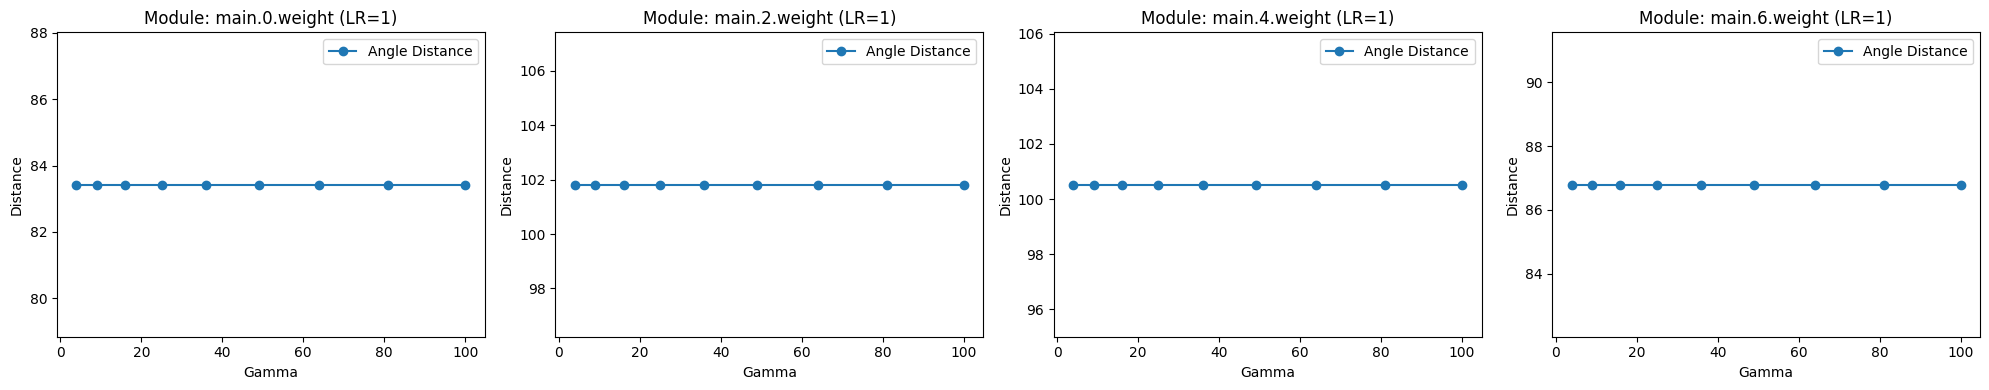

In [10]:
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
# checkpoint_steps = [1999,7999,13999,19999]

# print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma_list = [4, 9 , 16, 25, 36, 49, 64, 81, 100]
distance_module_dict = {}
for gamma in gamma_list:
    vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    lora_config = LoraConfig(
        r=2,
        lora_alpha=16,
        target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
        init_lora_weights="gaussian",
    )
    vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
    with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/fullP16000_step0_data_new_iter_15000.pkl', 'rb') as f:
        named_grad = pickle.load(f)
    _ = reinit_lora(vf_lora_reinit, gamma, named_grad)
    state_dict = vf_lora_reinit.state_dict()


    layer_num  = [0, 2, 4, 6]

    # Select modules for comparison
    module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                    "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                    #    "main.8.weight", "main.8.bias"
                    ]
    checkpoint_steps = [2000, 4000, 6000, 8000, 10000]
    ckpt = 2000

    # Calculate distance between original weights + lora_weights & trained weights


    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/lora_16000/{ckpt}_new'
    # Full model finetuned weights
    # peft_config = PeftConfig.from_pretrained(weight_path)
    vf_lora_compare = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    vf_lora_compare = PeftModel.from_pretrained(vf_lora_compare, weight_path)
    
    print(weight_path)
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights = loraB_weights @ loraA_weights

        # Load lora_combined weights for the compare model
        loraB_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights_compare = loraB_weights_compare @ loraA_weights_compare
        
        # distance = torch.norm(after_optimization_weights - weights).item()
        
        weight_1=loraA_weights
        weight_2=loraA_weights_compare

        # distance = wasserstein_distance(weight_1.cpu().numpy().flatten(), weight_2.cpu().numpy().flatten())
        
        dot_product = np.dot(weight_1.flatten().cpu().numpy(), weight_2.flatten().cpu().numpy())
        norm_after = np.linalg.norm(weight_1.flatten().cpu().numpy())
        norm_weights = np.linalg.norm(weight_2.flatten().cpu().numpy())
        distance = np.arccos(dot_product / (norm_after * norm_weights)) / np.pi * 180
        print(f"Gamma: {gamma}, Module: {module}, LR: {1}, Distance: {distance}")
        distance_module_dict[(gamma, module, 1)] = distance
        # if (module, "random") not in distance_module_dict:
        #     dis_random = wasserstein_distance(torch.randn_like(weight_2).cpu().numpy().flatten(), weight_1.cpu().numpy().flatten())
        #     distance_module_dict[(module, "random")] = dis_random
# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]

for idx, module in enumerate(modules):
    gammas = gamma_list
    distances = [distance_module_dict[(gamma, module, lr_fixed)] for gamma in gammas]
    axs[idx].plot(gammas, distances, marker='o', label='Angle Distance')
    # Plot a horizontal line for the single random reference value
    # random_ref = distance_module_dict[(module, "random")]
    # axs[idx].axhline(y=random_ref, linestyle='--', color='red', label='Random Reference')
    axs[idx].set_xlabel("Gamma")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
    axs[idx].legend()
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()